In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

import time

random_state = 6
np.random.seed(random_state)
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
get_ipython().run_line_magic('matplotlib', 'inline')

# latex parameter
font = {
    'family': 'serif', 
    'serif': ['Computer Modern Roman'],
    'weight' : 'regular',
    'size'   : 18
    }

plt.rc('font', **font)
plt.rc('text', usetex=False)
# plt.style.use('classic')

color_map = 'viridis'

In [6]:
df_train = pd.read_csv('../input/train.csv', na_values=-1)
df_test = pd.read_csv('../input/test.csv', na_values=-1)

### Check if both test and train have the same shape

In [7]:
print('Training data shape: {}'.format(df_train.shape))
print('Training data shape: {}'.format(df_test.shape))

Training data shape: (595212, 59)
Training data shape: (892816, 58)


### Check if there are any missing values

In [8]:
print('Is null on train: {}'.format(df_train.isnull().any().any()))
print('Is null on test: {}'.format(df_test.isnull().any().any()))

Is null on train: True
Is null on test: True


### Descriptive statistics

In [9]:
df_train.describe()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,5.952120e+05,595212.000000,595212.000000,594996.000000,595212.000000,595129.000000,589403.000000,595212.000000,595212.000000,595212.000000,...,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,7.438036e+05,0.036448,1.900378,1.359799,4.423318,0.416992,0.419038,0.393742,0.257033,0.163921,...,5.441382,1.441918,2.872288,7.539026,0.122427,0.627840,0.554182,0.287182,0.349024,0.153318
std,4.293678e+05,0.187401,1.983789,0.663193,2.699902,0.493062,1.350023,0.488579,0.436998,0.370205,...,2.332871,1.202963,1.694887,2.746652,0.327779,0.483381,0.497056,0.452447,0.476662,0.360295
min,7.000000e+00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.719915e+05,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,1.000000,2.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.435475e+05,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.000000,1.000000,3.000000,7.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.115549e+06,0.000000,3.000000,2.000000,6.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,7.000000,2.000000,4.000000,9.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,1.488027e+06,1.000000,7.000000,4.000000,11.000000,1.000000,6.000000,1.000000,1.000000,1.000000,...,19.000000,10.000000,13.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Heatmap 

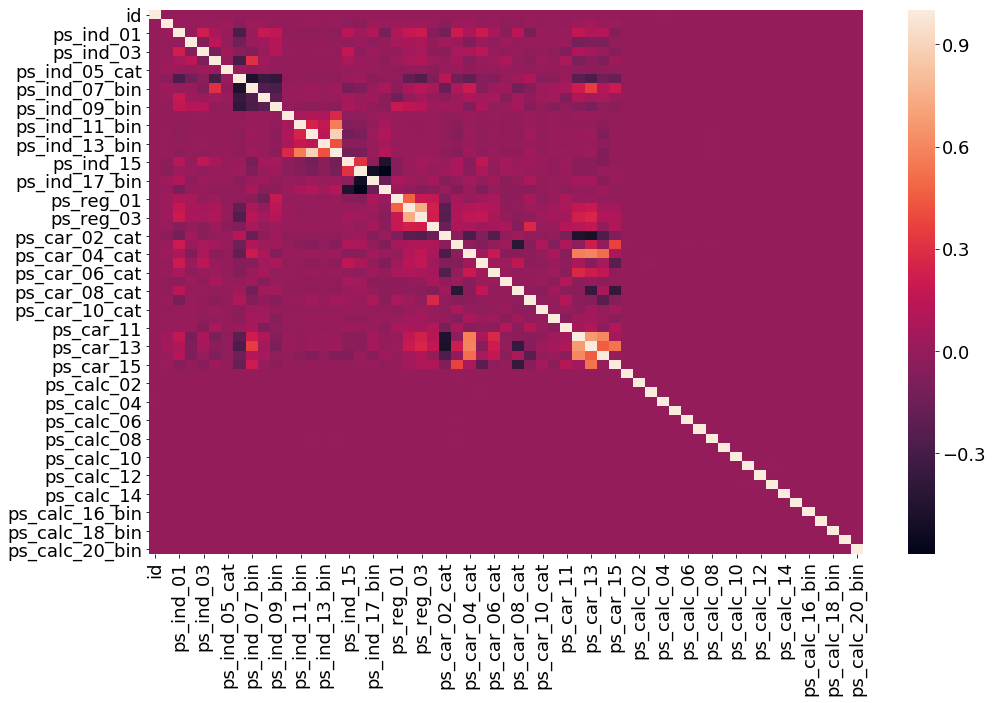

In [10]:
import seaborn as sns
cor = df_train.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)

#### Since 'ps_calc' features do not show any have zero relationship with other features
#### We can delete them.

In [11]:
col_to_drop = list(df_train.columns[df_train.columns.str.startswith('ps_calc_')])
df_train = df_train.drop(col_to_drop, axis=1)  
df_test = df_test.drop(col_to_drop, axis=1)

## Work with missing values

In [12]:
def get_missing_features(df):
    missings = pd.DataFrame([], columns=['feature', 'no_recoreds', 'percentage'])
    total_rows = df.shape[0]
    index = 0
    for feature in list(df):
        total_nulls = df[feature].isnull().sum()
        if total_nulls > 0:
            missings_perc = total_nulls / total_rows
            missings.loc[index] = [feature, total_nulls, missings_perc]
            index += 1
    missings = missings.sort_values('no_recoreds', ascending=False)
    return missings

In [13]:
df_missings = get_missing_features(df_train)
print(df_missings)

          feature no_recoreds  percentage
6   ps_car_03_cat      411231    0.690898
7   ps_car_05_cat      266551    0.447825
3       ps_reg_03      107772    0.181065
12      ps_car_14       42620    0.071605
8   ps_car_07_cat       11489    0.019302
2   ps_ind_05_cat        5809    0.009760
9   ps_car_09_cat         569    0.000956
0   ps_ind_02_cat         216    0.000363
4   ps_car_01_cat         107    0.000180
1   ps_ind_04_cat          83    0.000139
5   ps_car_02_cat           5    0.000008
10      ps_car_11           5    0.000008
11      ps_car_12           1    0.000002


### Bar plot of missing features

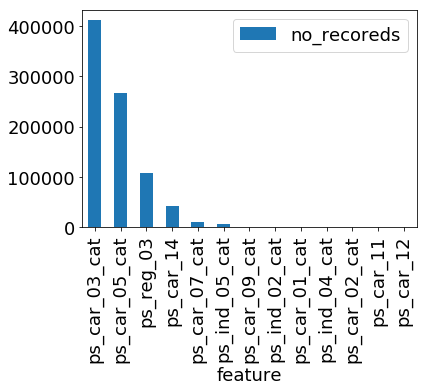

In [14]:
df_missings.plot(x='feature', y='no_recoreds', kind='bar', )

**Treat missing values by mode of the column**

In [15]:
for i, feature in enumerate(list(df_train.drop(['id'], axis=1))):
    if df_train[feature].isnull().sum() > 0:
        df_train[feature].fillna(df_train[feature].mode()[0],inplace=True)

for i, feature in enumerate(list(df_test.drop(['id'], axis=1))):
    if df_test[feature].isnull().sum() > 0:
        df_test[feature].fillna(df_test[feature].mode()[0],inplace=True)

### Check if there are any missing values

In [16]:
get_missing_features(df_train)
get_missing_features(df_test)

,feature,no_recoreds,percentage


## Check category features of the dataset

In [17]:
cat_cols = [col for col in df_train.columns if '_cat' in col]
dummed_cols = []

for cat_col in cat_cols:
    unique_values = len(np.unique(df_train[cat_col]))
    if unique_values < 50:
        dummed_cols.append(cat_col)
    print('{} has {} unique values'.format(cat_col, unique_values))

ps_ind_02_cat has 4 unique values
ps_ind_04_cat has 2 unique values
ps_ind_05_cat has 7 unique values
ps_car_01_cat has 12 unique values
ps_car_02_cat has 2 unique values
ps_car_03_cat has 2 unique values
ps_car_04_cat has 10 unique values
ps_car_05_cat has 2 unique values
ps_car_06_cat has 18 unique values
ps_car_07_cat has 2 unique values
ps_car_08_cat has 2 unique values
ps_car_09_cat has 5 unique values
ps_car_10_cat has 3 unique values
ps_car_11_cat has 104 unique values


## Transform category features to dummies

In [18]:
id_test = df_test['id'].values
y = df_train['target'].values

df_train = df_train.drop(['target','id'], axis = 1)
df_test = df_test.drop(['id'], axis = 1)

cat_features = [a for a in df_train.columns if a.endswith('cat')]

for column in cat_features:
    temp = pd.get_dummies(pd.Series(df_train[column]))
    df_train = pd.concat([df_train,temp],axis=1)
    df_train = df_train.drop([column],axis=1)
    
for column in cat_features:
    temp = pd.get_dummies(pd.Series(df_test[column]))
    df_test = pd.concat([df_test,temp],axis=1)
    df_test = df_test.drop([column],axis=1)

print(df_train.values.shape, df_test.values.shape)

(595212, 198) (892816, 198)


### Gini coeficient 

In [20]:
# from https://www.kaggle.com/mashavasilenko/
# porto-seguro-xgb-modeling-and-parameters-tuning
def eval_gini(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    ntrue = 0
    gini = 0
    delta = 0
    n = len(y_true)
    for i in range(n-1, -1, -1):
        y_i = y_true[i]
        ntrue += y_i
        gini += y_i * delta
        delta += 1 - y_i
    gini = 1 - 2 * gini / (ntrue * (n - ntrue))
    return gini


def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = -eval_gini(labels, preds)
    return [('gini', gini_score)]

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

### Ensembling

In [21]:
from sklearn.model_selection import StratifiedKFold

class Create_ensemble(object):
    def __init__(self, n_splits, base_models):
        self.n_splits = n_splits
        self.base_models = base_models

    def predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=random_state).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        
        for i, clf in enumerate(self.base_models):
            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, valid_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_valid = X[valid_idx]
                y_valid = y[valid_idx]
                
                clf.fit(X_train, y_train)
                valid_pred = clf.predict_proba(X_valid)[:,1]
                S_train[valid_idx, i] = valid_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            
            print( "\nTraining Gini for model {} : {}".format(i, eval_gini(y, S_train[:,i])))
            S_test[:, i] = S_test_i.mean(axis=1)
            
        return S_train, S_test

## Lightbm model

In [22]:
# LightGBM params
lgb_params = {}
lgb_params['learning_rate'] = 0.02
lgb_params['n_estimators'] = 700
lgb_params['max_bin'] = 15
lgb_params['subsample'] = 0.8
lgb_params['subsample_freq'] = 10
lgb_params['colsample_bytree'] = 0.8   
lgb_params['min_child_samples'] = 800
lgb_params['random_state'] = random_state
lgb_params['scale_pos_weight'] = 3

lgb_params2 = {}
lgb_params2['learning_rate'] = 0.02
lgb_params2['n_estimators'] = 900
lgb_params2['max_bin'] = 20
lgb_params2['subsample'] = 0.8
lgb_params2['subsample_freq'] = 10
lgb_params2['colsample_bytree'] = 0.8   
lgb_params2['min_child_samples'] = 600
lgb_params2['random_state'] = random_state
lgb_params2['scale_pos_weight'] = 3

lgb_model = LGBMClassifier(**lgb_params)
lgb_model2 = LGBMClassifier(**lgb_params2)

In [ ]:
lgb_stack = Create_ensemble(n_splits = 5, base_models = [lgb_model, lgb_model2])        
X = df_train
Y = y
T = df_test
lgb_train_pred, lgb_test_pred = lgb_stack.predict(X, Y, T)

In [ ]:
# Create submission file
sub = pd.DataFrame()
sub['id'] = id_test
sub['target'] = lgb_test_pred.mean(axis=1)
sub.to_csv('lightgbm_submit_ensemble_features.csv', float_format='%.6f', index=False)

## correlation among the model results

In [ ]:
import seaborn as sns
test_pred_df = pd.DataFrame(data = lgb_test_pred)
cor = test_pred_df.corr()
plt.figure(figsize=(16,10))
sns.heatmap(cor)